In [ ]:
import numpy as np
import time
from sklearn.mixture import GaussianMixture as GMM
from scipy.stats import norm,multivariate_normal,lognorm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
%matplotlib inline

# Simulation and Likelihood Estimation

In [41]:
MarkFunction="lognormal"
mean=1
variance=1
gamma=0.5
#def markedDepenenceLambdaLN(mean,sd,value):
#    p=0.5
#    return p
def markedDepenenceLambda(beta,value):
    p=-(np.log(1-value))/beta
    return p
def markedDepenenceLambdaLN(mean,sd,value):
    p=np.random.lognormal(mean, sd, 1)[0]
    return p

def markedFactorMultplied(p,gamma):
    return gamma*np.log(p+ 1)
    
    

def markedFactorMultplied1(p,gamma):
    
    return p

def markedDepenenceLambda1(mu,sd,value):
    p=np.sqrt(-2*np.log(value*sd*np.sqrt(2*np.pi)))*sd+mu
    return p

def markFunction(A,alpha,mark):
    return A*np.exp(alpha*mark)

def function_kernel(k,theta,tau,c):
    kernel=k*(tau+c)**(-1-theta)
    return kernel

def function_kernel1(theta,tau):
    kernel=-0.4*(np.exp(-theta*tau))
    return kernel

def function_kernel2(theta,tau):
    kernel=np.ones(len(tau))*0.01
    return kernel

def markToKernel(marks):
    gm = np.ones((len(marks)))
    #gm=gm*marks
    return gm




def simu_univariateMarked1(mu,theta,beta,T,mean=0,variance=0):    
    s=0
    tau=[]
    lambda_val=[]
    l2=[]  
    g_x=np.random.uniform(0.0,1.0,1)[0]
    marks=1
    threshold=1
    lambda_s=mu
    while s<T:
        sum1=0
        new_tau = np.array(tau[::-1])
        l3=np.array(l2[::-1])
        sum1=(function_kernel1(theta,s-new_tau[0:])*(markedFactorMultplied(l3[0:],gamma))).sum()
        lambda_ = max(mu,mu + threshold+ sum1)

        u=np.random.uniform(0,1,1)[0]
        w=-np.log(u)/lambda_
        s=s+w
        d=np.random.uniform(0,1,1)[0]
        sum1=(function_kernel1(theta,s-new_tau[0:])*(markedFactorMultplied(l3[0:],gamma))).sum()
    
        lambda_s = max(mu +  sum1,0)
        if (d*lambda_<=lambda_s):
            tau.append(s)
            g_x=np.random.uniform(0.0,1.0,1)[0]
            if MarkFunction=="lognormal":
                marks=markedDepenenceLambdaLN(mean,variance,g_x)
            else:
                marks=markedDepenenceLambda(beta,g_x)
            l2.append(marks)
        #if (len(tau))>3000:
         #   break
    return np.array(tau[:-1]),np.array(np.array(l2[:-1]))
def loglikelihood(para,t,marks):
    theta=para[0]
    beta =para[1]
    mu=para[2]
    tend = t[-1]-t
    ll=mu*(t[-1]-t[0])
    llIn=((1-np.exp(-theta*tend))/theta*marks).sum()
    ll+=llIn
    print('Integrated Value',llIn)
    for i in range(0,len(t),1):
        temp = t[i]-t[0:i]
        markTemp=marks[0:i]
        logLam = -np.log(max(mu+(markTemp*np.exp(-theta*temp)).sum(),1e-8))
        ll = ll+logLam
    print("log Part",ll-llIn)
    if MarkFunction=="lognormal":
        markFunctionSum=(np.log(np.exp((-(np.log(marks) - mean)**2) / (2 * variance))/ 
                         (marks * np.sqrt(2 * np.pi*variance)))).sum()
    else:
        
        markFunctionSum=(np.log(beta*np.exp(-beta*marks))).sum()    
    print("mark Function Sum",markFunctionSum)
    ll-=markFunctionSum
    return ll


In [42]:
mu_t,theta,betax=0.9,2.0,0.2
t1,marksO=simu_univariateMarked1(mu_t,theta,betax,10000,mean,variance)



# GMM Estimation for Mark Function

In [43]:
def mark_distribution(marks):
    x =marks
    x = x.reshape(-1, 1)
    optimal_checks=20
    bestAIC=1e8
    for j in range(1,optimal_checks):
        gmm = GMM(n_components = j, max_iter=1000, random_state=10,covariance_type = 'full')
        g=gmm.fit(x)
        AIC=gmm.aic(x)
        if bestAIC>AIC:
            n_optimal=j
            bestAIC= AIC
# create GMM model object
    gmm = GMM(n_components = n_optimal, max_iter=1000, random_state=10, reg_covar=2e-02, covariance_type = 'full')

# find useful parameters
    g=gmm.fit(x)
    mean = g.means_  
    covs  = g.covariances_
    weights = g.fit(x).weights_

# create necessary things to plot
    x_axis = np.sort(marks)
    y_axis0=0


    for j in range(n_optimal):
        y_axis0 += norm.pdf(x_axis, float(mean[j][0]), np.sqrt(float(covs[j][0][0])))*weights[j]# 1st gaussian

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1,2,2)
# Plot 2
    plt.hist(x, density=True, bins=1000, color='black')

    plt.plot(x_axis, y_axis0, lw=3, c='C2', ls='dashed')


#plt.ylim(0.0, 2.0)
    plt.xlabel(r"X", fontsize=20)
    plt.ylabel(r"Density", fontsize=20)

    plt.subplots_adjust(wspace=0.3)
    plt.show()
    plt.close('all')
    print(n_optimal)

    return -(np.log(y_axis0)).sum()

# Estimation

In [44]:


#combined Mu and Kernel
def nnMuKernel(x,diffx,diffmark,mu,c):
    kernelSum=(nnKernel(x-diffx,diffmark)).sum()
    y=max(mu+kernelSum,epsilon)+c
    return y

#Kernel Calcualtion
def nnKernel(diffx,diffmark):
    alphas = A[0]
    alpha0 = A[1]
    betas1 = B[0]
    betas2 = B[1]
    beta0 = B[2]
    n1 = np.maximum(betas1*diffx.reshape(1,-1) + betas2*diffmark.reshape(1,-1)+beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0

    return y

#integrated mu and kernel
def nnIntegrateMuKernel(iArray,mu,t,marks,c):

    IntegratedLambda=np.array(Parallel(n_jobs=50)(delayed(nnIntegratedParallel)(j,mu,t,marks,c) for j in np.nditer(iArray)),dtype=object)

    return IntegratedLambda.sum()

def nnIntegratedParallel(j,mu,t,marks,c):
    inflection1=Dict['inflection1'].reshape(-1)
    inflection2=Dict['inflection2'].reshape(-1)
    tj=t[j]
    if j>0 and tj>t[0]:
        li = max(j-support,0)
        iP=t[j-1]
        temp=t[li:j]
        marktemp=marks[li:j]
        
        inflectionPs=inflection1+inflection2*marktemp.reshape(-1,1)+temp.reshape(-1,1)
        inflectionPs=inflectionPs.reshape(-1)
        inflectionPs=np.sort(inflectionPs)
        inflectionPs=inflectionPs[(inflectionPs>iP)*(inflectionPs<tj)]
        inflectionPs=np.append(iP,inflectionPs)
        inflectionPs=np.append(inflectionPs,tj)
        IntegratedLambda=nnIntegrateMuKernelPart(tj,iP,temp,marktemp,inflectionPs,mu,c)
    else:
        IntegratedLambda=0
    return IntegratedLambda
            
def outerIps(inflectionPs,temp,tempMark,mu):
    alphas = A[0]
    alpha0 = A[1]
    betas1 = B[0]
    betas2 = B[1]
    beta0 = B[2]
    inflection=[]
    infl1=-100
    for j in range(1,len(inflectionPs)):
        iP1=inflectionPs[j]
        iP2=inflectionPs[j-1]
        v1=-mu
        v2=0
        
        n1=betas1*(iP1-temp-epsilon).reshape(1,-1)+betas2*tempMark.reshape(1,-1)+beta0
        dn1=(n1>0)
        v3=-len(temp)*alpha0[0]-(alphas*beta0*dn1).sum()-(alphas*betas2*tempMark.reshape(1,-1)*dn1).sum()+(alphas*betas1*dn1*(temp).reshape(1,-1)).sum()
        v4=(alphas*betas1*dn1).sum()
        infl=(v1+v3)/(v2+v4)
        if (iP1>infl) & (iP2<infl) &(infl1!=infl):
            infl1=infl
            inflection.append(infl)
    return np.array(inflection)

def lambdaVs(temp,tempMark,inflectionPs,mu):
    alphas = A[0]
    alpha0 = A[1]
    betas1 = B[0]
    betas2 = B[1]
    beta0 = B[2]
    marksP=tempMark-np.zeros(len(inflectionPs)).reshape(-1,1)
    n1=np.maximum(betas1*(inflectionPs.reshape(-1,1)-temp).reshape(1,-1)+betas2*marksP.reshape(1,-1)+beta0,0)
    n2=np.sum(A[0]*n1,axis=0)+A[1]
    n2=n2.reshape(len(inflectionPs),len(temp))
    y=np.sum(n2,axis=1)+mu
    return y
    
def nnIntegrateMuKernelPart(tj,iP,temp,tempMark,inflectionPs,mu,c):
  
    alphas = A[0]
    alpha0 = A[1]
    betas1 = B[0]
    betas2 = B[1]
    beta0 = B[2]


    lambdaValInfl=lambdaVs(temp,tempMark,inflectionPs,mu)
    
    
    if len(lambdaValInfl<=0)!=0:
        oIp=[]
        oIp.append(inflectionPs[0])
        for j in range(1,len(inflectionPs)):
            if ((lambdaValInfl[j]<=0) and (lambdaValInfl[j-1]>0)) or ((lambdaValInfl[j]>0) and (lambdaValInfl[j-1]<=0)):
                if (oIp[-1]==inflectionPs[j-1]):
                    oIp.append(inflectionPs[j])
                else:
                    oIp.append(inflectionPs[j-1])
                    oIp.append(inflectionPs[j])
        oIp=np.array(oIp)
        outerInflections=outerIps(oIp,temp,tempMark,mu)
        if len(outerInflections)!=0:
            inflectionPs=np.concatenate((inflectionPs,outerInflections))
            inflectionPs=np.sort(inflectionPs)
    
    integral=0
    for k in range(1,len(inflectionPs)):
        iP1=inflectionPs[k]
        iP2=inflectionPs[k-1]
        
        n1=np.maximum(betas1*(iP1-temp-epsilon).reshape(1,-1)+betas2*tempMark.reshape(1,-1)+beta0,0)
        dn1=(n1>0)
        n2=(np.dot(alphas.T,n1)+alpha0).sum()
        
        dn2=((mu+n2)>0)
        if dn2!=0:
            term1Mu=mu*iP1
            term2Mu=mu*iP2
            temp1=(iP1-temp).reshape(1,-1)
            temp2=(iP2-temp).reshape(1,-1)
            tempMarkbetas=betas2*tempMark.reshape(1,-1)
        
            term1Kernel=(alpha0*iP1*len(temp)+np.sum(alphas*temp1*(beta0+tempMarkbetas+(0.5*temp1)*betas1)*dn1,axis=0)).sum()
            term2Kernel=(alpha0*iP2*len(temp)+np.sum(alphas*temp2*(beta0+tempMarkbetas+(0.5*temp2)*betas1)*dn1,axis=0)).sum()
        
        
            integral+=(term1Mu- term2Mu+ term1Kernel- term2Kernel)*dn2+c*(iP1-iP2)
     
    return integral
        

   
    
#Mu and Kernel Likelihood
def nnLoglikelihoodval(iArray,t,marks,mu,c):
    ll=0
    llIn=nnIntegrateMuKernel(iArray,mu,t,marks,c)
    print("Integrated Part Mu and kernel ",llIn)
    ll=ll+llIn
    for i in range(1,len(t)):
        li = max(i-support,0)
        
        temp = t[li:i]
        tempMark=marks[li:i]
        MuKernel=nnMuKernel(t[i],temp,tempMark,mu,c)
        logLam = -np.log(MuKernel)
        ll = ll+logLam
    print("log Part",ll-llIn)
    return ll    

def nnLoglikelihood(iArray,t,marks,mu,c):
    ll=0
    llIn=nnIntegrateMuKernel(iArray,mu,t,marks,c,t_train)
    print("Integrated Part Mu and kernel ",llIn)
    ll=ll+llIn

    for i in range(1,len(t)):
        li = max(i-support,0)
        temp = t[0:i]
        tempMark=marks[0:i]
        MuKernel=nnMuKernel(t[i],temp,tempMark,mu,c)
        logLam = -np.log(MuKernel)
        ll = ll+logLam
    print("log Part",ll-llIn)
    return ll+markFunctionLL


#Mu and Kernel combined Gradients
def gradientsMuKernel(mu,train,marks,iArray,c):
    alphas = A[0]
    gradMu=0
    
    gradA=np.zeros((len(alphas),1))*0
    gradB1=np.zeros((len(alphas),1))*0
    gradB2=np.zeros((len(alphas),1))*0
    gradB0=np.zeros((len(alphas),1))*0
    gradA0=0
    gradC=0
    
    
    gradients=np.array(Parallel(n_jobs=50)(delayed(gradientsMuKernelParallel)(mu,train,marks,c,j) for j in np.nditer(iArray)),dtype=object)
    
    gradMu+=(gradients[:,0]).sum()

        
    gradA+=(gradients[:,1]).sum()
    gradA0+=(gradients[:,2]).sum()
    gradB1+=(gradients[:,3]).sum()
    gradB2+=(gradients[:,4]).sum()
    gradB0+=(gradients[:,5]).sum()
    gradC+=(gradients[:,6]).sum()
    
    length=len(iArray)
        
    gradMu=gradMu/length
    gradA,gradA0,gradB1,gradB2,gradB0=gradA/length,gradA0/length,gradB1/length,gradB2/length,gradB0/length
  
    


    gradC  = gradC/length
    
    mus1grad[0]=gradMu
    A_grad[0] = gradA.astype('float32')
    A_grad[1] = gradA0
    B_grad[0] = gradB1.astype('float32')
    B_grad[1] = gradB2.astype('float32')
    B_grad[2] = gradB0.astype('float32')
    musCgrad[0]=gradC

    return

def gradientsMuKernelPart(mu,tj,iP,inflectionPs,temp,tempMark,c):
    alphas = A[0]
    alpha0 = A[1]
    betas1 = B[0]
    betas2 = B[1]
    beta0 = B[2]

    lambdaValInfl=lambdaVs(temp,tempMark,inflectionPs,mu)
    
    oIp=[]
    if len(lambdaValInfl<=0)!=0:
        oIp.append(inflectionPs[0])
        for j in range(1,len(inflectionPs)):
            if ((lambdaValInfl[j]<=0) and (lambdaValInfl[j-1]>0)) or ((lambdaValInfl[j]>0) and (lambdaValInfl[j-1]<=0)):
                if (oIp[-1]==inflectionPs[j-1]):
                    oIp.append(inflectionPs[j])
                else:
                    oIp.append(inflectionPs[j-1])
                    oIp.append(inflectionPs[j])
        oIp=np.array(oIp)
        outerInflections=outerIps(oIp,temp,tempMark,mu)
        if len(outerInflections)!=0:
            inflectionPs=np.concatenate((inflectionPs,outerInflections))
            inflectionPs=np.sort(inflectionPs)

    gradMu=0
    gradA=np.zeros((len(alphas),1))*0
    gradB1=np.zeros((len(alphas),1))*0
    gradB2=np.zeros((len(alphas),1))*0
    gradB0=np.zeros((len(alphas),1))*0
    gradA0=0
    gradC=0
    for k in range(1,len(inflectionPs)):
        iP1=inflectionPs[k]
        iP2=inflectionPs[k-1]
        Mn2=mu
        
        n1=np.maximum(betas1*(iP1-temp-epsilon).reshape(1,-1)+betas2*tempMark.reshape(1,-1)+beta0,0)
        dn1=(n1>0)
  
        n2=(np.dot(alphas.T,n1)+alpha0).sum()
     
        dn2=((Mn2+n2)>0)
        
        if dn2!=0:
            gradMu+=(iP1-iP2)*dn2*(iP2>0)        
            temp1=(iP1-temp).reshape(1,-1)
            temp2=(iP2-temp).reshape(1,-1)
            tempMarkbetas=betas2*tempMark.reshape(1,-1)
            ck1=(np.sum(temp1*(beta0+tempMarkbetas+betas1*(0.5*temp1).reshape(1,-1))*dn1,axis=1)).reshape(-1,1)
            ck2=(np.sum(temp2*(beta0+tempMarkbetas+betas1*(0.5*temp2).reshape(1,-1))*dn1,axis=1)).reshape(-1,1)
            gradA+= (ck1-ck2)*dn2
            gradA0+=(iP1-iP2)*len(temp)*dn2
            gradB1+=(np.sum((alphas*temp1*0.5*temp1*dn1-alphas*temp2*0.5*temp2*dn1),axis=1)*dn2).reshape(-1,1)
            gradB2+=(np.sum((alphas*iP1*tempMark.reshape(1,-1)*dn1-alphas*iP2*tempMark.reshape(1,-1)*dn1),axis=1)*dn2).reshape(-1,1)
            gradB0+=(np.sum((alphas*temp1*dn1-alphas*temp2*dn1),axis=1)*dn2).reshape(-1,1)
        gradC+=(iP1-iP2)*(iP2>0)
    gradKer=[gradA,gradA0,gradB1,gradB2,gradB0]
    return gradMu,gradKer,gradC

def gradientsMuKernelParallel(mu,t,marks,c,j):
    

    alphas = A[0]
    alpha0 = A[1]
    betas1 = B[0]
    betas2 = B[1]
    beta0 = B[2]

    tj=t[j]
    inflection1=Dict['inflection1'].reshape(-1)
    inflection2=Dict['inflection2'].reshape(-1)
    
    if j>0 and tj>t[0]:
        iP=t[j-1]
        lj=max(0,j-support)
        temp=t[lj:j]
        tempMark=marks[lj:j]
      
        inflectionPs=inflection1+inflection2*tempMark.reshape(-1,1)+temp.reshape(-1,1)
        inflectionPs=inflectionPs.reshape(-1)
        inflectionPs=np.sort(inflectionPs)
        inflectionPs=inflectionPs[(inflectionPs>iP)*(inflectionPs<tj)]
        inflectionPs=np.append(iP,inflectionPs)
        inflectionPs=np.append(inflectionPs,tj)
        gradMu,gradKer,gradCn=gradientsMuKernelPart(mu,tj,iP,inflectionPs,temp,tempMark,c)
        
        gradA=gradKer[0]
        gradA0=gradKer[1]
        gradB1=gradKer[2]
        gradB2=gradKer[3]
        gradB0=gradKer[4]
  
        gradC=gradCn
        logPart=nnMuKernel(tj,temp,tempMark,mu,c)

        inverseLog=1/logPart
        Mn2=mu
         
        n1=np.maximum(betas1*(tj-temp).reshape(1,-1)+betas2*tempMark.reshape(1,-1)+beta0,0)
        dn1=(n1>0)
  
        n2=np.dot(alphas.T,n1)+alpha0
    
        dn2=((n2+Mn2).sum()>0)
     
        if dn2!=0:
            
            gradMu-=1*inverseLog*(j>0)
            gradA0-=(len(temp))*inverseLog
            gradA-=(np.sum(n1,axis=1)).reshape(-1,1)*inverseLog
            
            gradB1-=(np.sum(alphas*(tj-temp).reshape(1,-1)*dn1,axis=1)).reshape(-1,1)*inverseLog
            gradB2-=(np.sum(alphas*tempMark.reshape(1,-1)*dn1,axis=1)).reshape(-1,1)*inverseLog
            gradB0-=(np.sum(alphas*dn1,axis=1)).reshape(-1,1)*inverseLog
        gradC-=(1*inverseLog)*(tj>0)
    else:
        
        gradA=gradB1=gradB2=gradB0=np.zeros((len(alphas),1))
        gradA0=gradMu=gradC=0
        
    return gradMu,gradA,gradA0,gradB1,gradB2,gradB0,gradC



# SGD 

In [45]:
def nnKernelMatrix(x,y):
    z=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        z[i,:]=nnKernel(x[i,:],y[i,:]).reshape(-1)
            
    return z
def plotKernels():
    dx=0.1
    
    marksplot=np.sort(marks1)
    lengthMarks=len(marksplot)
    marksMin=marksplot[int(0.05*lengthMarks)]
    marksMax=marksplot[int(0.95*lengthMarks)]
    diff_t=np.diff(tscale)
    diff_tSort=np.sort(diff_t)
    length_difftSort=len(diff_tSort)
    diffMin= diff_tSort[int(0.05*length_difftSort)]
    diffMax= diff_tSort[int(0.95*length_difftSort)]
    tk =np.arange(diffMin,diffMax,dx)
    marksP=np.linspace(marksMin,marksMax,len(tk))
    
    
    X, Y = np.meshgrid(tk, marksP)
    if(kernelType == 0):
        #y = alpha*np.exp(-beta*tk)
        Z=markedFactorMultplied(Y/facM,gamma)*function_kernel1(theta,X)
        Z2=nnKernelMatrix(X,Y)*fac            
    
    fig = plt.figure(figsize=(8,6))
 
  
    ax = plt.axes(projection ='3d')

    surf=ax.plot_wireframe(X/fac, Y/facM, Z, cmap="Blues",
                       rstride=2, cstride=2, alpha=0.8,color="blue",label="real")
    surf1 = ax.plot_wireframe(X/fac, Y/facM, Z2, cmap="Reds",
                       rstride=2, cstride=2, alpha=0.8,color="red",label="Method")
    fig.colorbar(surf, label='Real Value')
    fig.colorbar(surf1, label='New Method')
    ax.set_xlabel('time')
    ax.set_ylabel('Marks')
    ax.set_zlabel('$\phi$')
    
    plt.grid()
    plt.pause(0.0005)
    tk = np.arange(0,5,dx)
    
    marks2=np.arange(marksMin,marksMax,dx)

    dp=1
    fig = plt.figure(figsize=(8,6))
    X1=np.linspace(marksMin,marksMax,4)
    R=np.linspace(0.0,1,len(X1))
    G=np.linspace(0,0.5,len(X1))
    B=np.linspace(0,0.5,len(X1))
    for j in range(len(X1)):

        plt.plot(tk/fac,nnKernel(tk/fac,np.ones(len(tk))*X1[j]*facM).reshape(-1)*fac,label='Marks=%.2f'%X1[j],color=(R[j],G[j],B[j]))
        plt.plot(tk/fac,markedFactorMultplied(X1[j],gamma)*function_kernel1(theta,tk),"--",color=(R[j],G[j],B[j]))
        plt.xlabel('t')
        plt.ylabel('$\phi$')


    plt.legend()

    plt.pause(0.005)

    fig = plt.figure(figsize=(8,6))
    X2=np.linspace(diffMin,diffMax,len(X1))
    for j in range(len(X2)):
        plt.plot(marksP,nnKernel(np.ones(len(marksP))*X2[j]/fac,marksP*facM).reshape(-1)*fac,label='t=%.2f'%X2[j],color=(R[j],G[j],B[j]))
        plt.plot(marksP,markedFactorMultplied(marksP,gamma)*function_kernel1(theta,X2[j]),"--",color=(R[j],G[j],B[j]))
        plt.xlabel('Marks')
        plt.ylabel('$\phi$')

    plt.legend()
    plt.pause(0.005)
               
                           
    return 0
    
def summaryData(marks,t,check_range=10):
    print("################## Dataset Summary ##################\n")
    
    print("mean of marks is",np.mean(marks))
    TS=[]
    final=0
    while final<t[-1]:
        initial=final
        final+=check_range
        TS.append((marks[(t>initial)*(t<final)]).sum())

    print("------------------------------------------------------------------------")
    print("mean of interarival times is",np.mean(np.diff(t)))
    print("Number of Data points Generated",len(t))
    print("#########################################################")
    return 0    
                           
def sgdNeuralHawkes(nEpochs,lr,mu,c,t1,marks1):        
    global t_test
    summaryData(t1,marks1)
    errorListTrain=[]
    errorListval=[]
    lr2 =lr*0.1
    lr_mu=lr*0.5
    beta_1 = 0.9
    beta_2 =0.999
  
    
    bestll = 1e20
    
    optimalParams=[A,B,mu,c,bestll]
      
    m_t_A = np.zeros([nNeurons,1])
    m_t_A0 =0
    m_t_B1= np.zeros([nNeurons,1])
    m_t_B2= np.zeros([nNeurons,1])
    m_t_B0= np.zeros([nNeurons,1])
    m_t = 0
    v_t_A = np.zeros([nNeurons,1])
    v_t_A0 =0
    v_t_B1= np.zeros([nNeurons,1])
    v_t_B2= np.zeros([nNeurons,1])
    v_t_B0= np.zeros([nNeurons,1])
    v_t = 0

    count = 0
    

    m_t_A0_Mu = 0
    v_t_A0_Mu = 0
    
    m_t_C=0
    v_t_C=0
    stopping_count=0

    splitTrain=int(0.7*len(t1))
    splitTest=int(0.85*len(t1))
    t_train=t1[0:splitTrain]
    mark_train=marks1[0:splitTrain]
    t_val=t1[splitTrain:splitTest]
    mark_val=marks1[splitTrain:splitTest]
    t_test=t1[splitTest:]
    mark_test=marks1[splitTest:]

   
    bsize=max(int(len(t_train)/100),100)
    stop=0
    for epochs in range(1,nEpochs+1,1):
                   
        rsample = np.random.choice(len(t_train),len(t_train),replace = False)
        for i in range(1,len(rsample), bsize):
       
            count=count+1 
            
            gradientsMuKernel(mu,t_train,mark_train,rsample[i:i+ bsize],c)
            
            #print(A[0],B[0],B[1],B[2],"next") 
            m_t_A = beta_1*m_t_A + (1-beta_1)*A_grad[0]	#updates the moving averages of the gradient
            v_t_A = beta_2*v_t_A + (1-beta_2)*(A_grad[0]*A_grad[0])	#updates the moving averages of the squared gradient
            m_cap_A = m_t_A/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A = v_t_A/(1-(beta_2**count))		#calculates the bias-corrected estimates
            A[0] = A[0]-(lr*m_cap_A)/(np.sqrt(v_cap_A)+epsilon)
            
            
            m_t_A0 = beta_1*m_t_A0 + (1-beta_1)*A_grad[1]	#updates the moving averages of the gradient
            v_t_A0 = beta_2*v_t_A0 + (1-beta_2)*(A_grad[1]*A_grad[1])	#updates the moving averages of the squared gradient
            m_cap_A0 = m_t_A0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A0 = v_t_A0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            #A[1] = A[1]-(lr*m_cap_A0)/(np.sqrt(v_cap_A0)+epsilon)
            
                
            m_t_B1 = beta_1*m_t_B1 + (1-beta_1)*B_grad[0]	#updates the moving averages of the gradient
            v_t_B1 = beta_2*v_t_B1 + (1-beta_2)*(B_grad[0]*B_grad[0])	#updates the moving averages of the squared gradient
            m_cap_B1 = m_t_B1/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B1= v_t_B1/(1-(beta_2**count))		#calculates the bias-corrected estimates
            B[0] = B[0]-(lr2*m_cap_B1)/(np.sqrt(v_cap_B1)+epsilon)
            
            m_t_B2 = beta_1*m_t_B2 + (1-beta_1)*B_grad[1]	#updates the moving averages of the gradient
            v_t_B2 = beta_2*v_t_B2 + (1-beta_2)*(B_grad[1]*B_grad[1])	#updates the moving averages of the squared gradient
            m_cap_B2 = m_t_B2/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B2= v_t_B2/(1-(beta_2**count))		#calculates the bias-corrected estimates
            B[1] = B[1]-(lr2*m_cap_B2)/(np.sqrt(v_cap_B2)+epsilon)
            
            
            m_t_B0 = beta_1*m_t_B0 + (1-beta_1)*B_grad[2]	#updates the moving averages of the gradient
            v_t_B0 = beta_2*v_t_B0 + (1-beta_2)*(B_grad[2]*B_grad[2])	#updates the moving averages of the squared gradient
            m_cap_B0 = m_t_B0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B0 = v_t_B0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            B[2] = B[2]-(lr2*m_cap_B0)/(np.sqrt(v_cap_B0)+epsilon)
            

            
            m_t_A0_Mu = beta_1*m_t_A0_Mu + (1-beta_1)*mus1grad[0]	#updates the moving averages of the gradient
            v_t_A0_Mu = beta_2*v_t_A0_Mu + (1-beta_2)*(mus1grad[0]*mus1grad[0])	#updates the moving averages of the squared gradient
            m_cap_A0_Mu = m_t_A0_Mu/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A0_Mu = v_t_A0_Mu/(1-(beta_2**count))		#calculates the bias-corrected estimates
            mu= mu-(lr_mu*m_cap_A0_Mu)/(np.sqrt(v_cap_A0_Mu)+epsilon)
            mu=max(mu,1e-3)
            
            
            m_t_C = beta_1*m_t_C + (1-beta_1)*musCgrad[0]	#updates the moving averages of the gradient
            v_t_C = beta_2*v_t_C + (1-beta_2)*(musCgrad[0]*musCgrad[0])	#updates the moving averages of the squared gradient
            m_cap_C = m_t_C/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_C = v_t_C/(1-(beta_2**count))		#calculates the bias-corrected estimates
            c= c-(lr_mu*0.01*m_cap_C)/(np.sqrt(v_cap_C)+epsilon)
            c=max(1e-3*fac,c*fac)
            c=min(1e-5*fac,c*fac)
            
            
            inflectionPoints()
            if count>=10:
                #error=nnLoglikelihoodTest(np.arange(20,len(t_test),1),t_test,mark_test,t_train,mu)
                error=nnLoglikelihoodval(np.arange(1,len(t_val),1),t_val,mark_val,mu,c)
                if(bestll > error):
                    A1=A[0].copy()
                    A2=A[1].copy()
                    B1=B[0].copy()
                    B2=B[1].copy()
                    B0=B[2].copy()
                    
                    optimalParams=[A1,A2,B1,B2,B0,mu,c,error]
                    bestll=error
                    stopping_count=0
                else:
                    stopping_count+=1
                count=0
            
                errorListval.append(error)
                print(i,epochs,bestll,error,mu*fac,c)
        
        if stopping_count>=10:
            return optimalParams,errorListval
        plotKernels()
    return optimalParams,errorListval
    


# Initialization and Inflection Points

In [46]:
#Inflection Points for kernel

def inflectionPoints():
    Dict.clear()
    div = B[0]+epsilon*(np.abs(B[0])<epsilon)
    x1 = -B[2]/div
    interestX = x1
    Dict['inflection1'] = interestX
    x2 = -B[1]/div
    interestXMark = x2
    Dict['inflection2'] = interestXMark
    

    return

def initializeParams(nNeurons,fac,facM):
    alphas = (np.random.uniform(0,1,nNeurons)).reshape(-1,1)*1.0
    alpha0 = -np.random.uniform(0,1,1)*0
    betas1=-(np.random.uniform(0,1,int(nNeurons))).reshape(-1,1)*0.7
    betas2=(np.random.uniform(-1,1,int(nNeurons))).reshape(-1,1)*0.2
    beta0 = np.random.uniform(0,1,int(nNeurons)).reshape(-1,1)*0.25
    #beta0=np.random.uniform(0,1,int(nNeurons))*0.
    #alphas = alpha_0.reshape(-1,1)
    #alpha0 = -np.random.uniform(0,1,1)*0
    #betas1 =beta_0.reshape(-1,1)
    #betas2 = beta_1.reshape(-1,1)
    #beta0 = beta_2.reshape(-1,1)
    
    

    
    mu =1
    #mu=1/fac
    #mu=mu_t

    c=np.random.normal(0,1,1)[0]*1e-3
    
    A.append(alphas)
    B.append(betas1)
    B.append(betas2)
    A.append(alpha0)
    B.append(beta0)

    
    
    A_grad.append(np.zeros([nNeurons,1]))
    A_grad.append(0)
    B_grad.append(np.zeros([nNeurons,1]))
    B_grad.append(np.zeros([nNeurons,1]))
    B_grad.append(np.zeros([nNeurons,1]))
    mus1grad.append(0)
    musCgrad.append(0)

    
    return mu,c

Integrated Value 17622.61342570634
log Part 4771.085361915066
mark Function Sum -18927.53475647977
original Likelihood 41321.233544101175


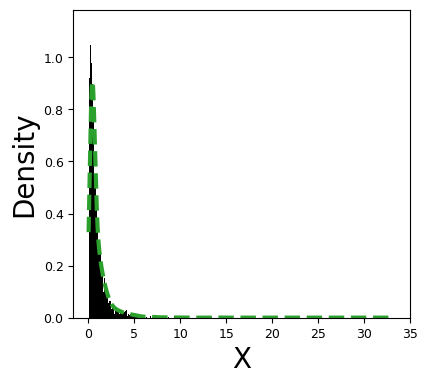

19
marksSum 7734.797742428405


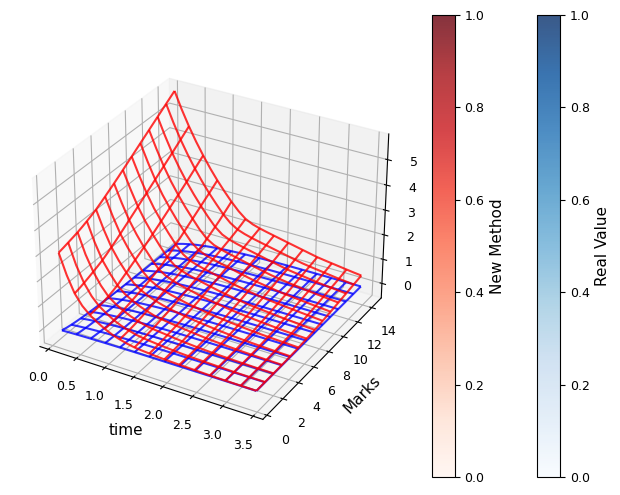

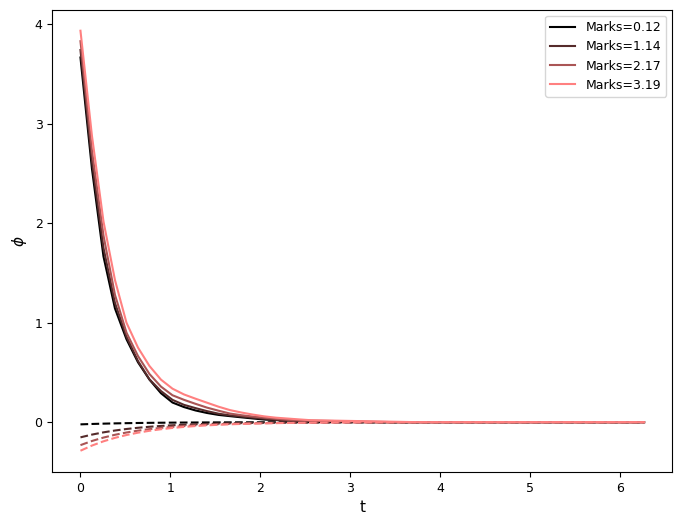

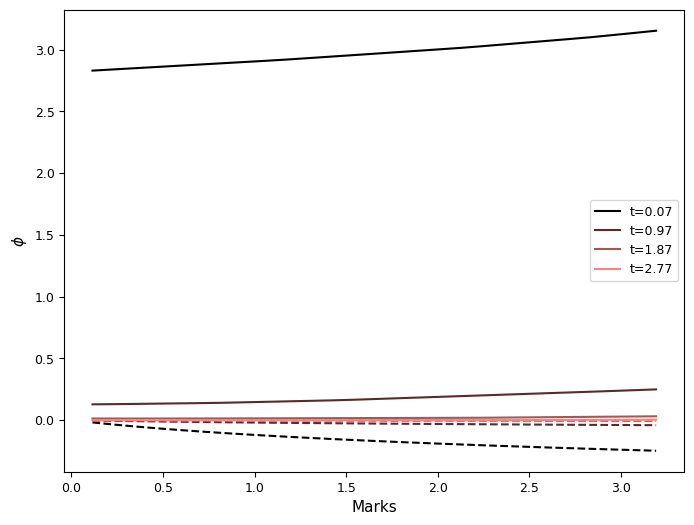

len of datapoints 7823


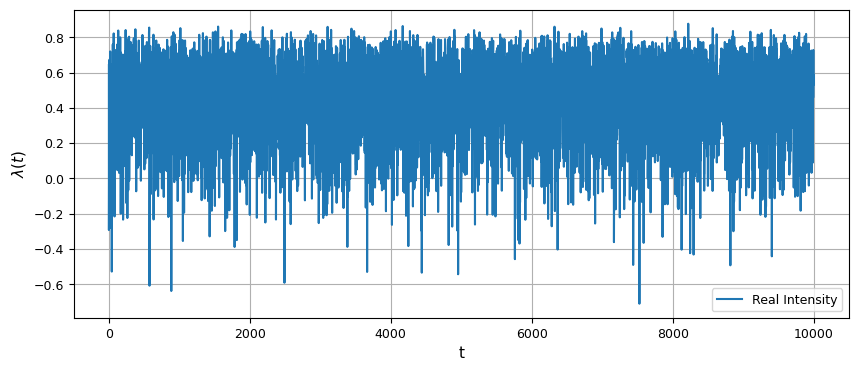

mean marks 4.505545079104211
################## Dataset Summary ##################

mean of marks foris 3874.0561913889933
------------------------------------------------------------------------
mean of interarival times is -6.664586497526416e-06
Number of Data points Generated 7823
#########################################################
Integrated Part Mu and kernel  3453.482734715091
log Part -840.6741750779474
901 1 2612.8085596371434 2612.8085596371434 0.7432789948489463 7.82414692593856e-06
Integrated Part Mu and kernel  2342.9578753219407
log Part -476.1709960261478
1901 1 1866.786879295793 1866.786879295793 0.698291745127271 7.82414692593856e-06
Integrated Part Mu and kernel  1662.3743677220125
log Part -178.01028258672272
2901 1 1484.3640851352898 1484.3640851352898 0.6641368059856957 7.82414692593856e-06
Integrated Part Mu and kernel  1197.2098078234762
log Part 101.54332116194314
3901 1 1298.7531289854194 1298.7531289854194 0.6476423631458583 7.82414692593856e-06
Integrate

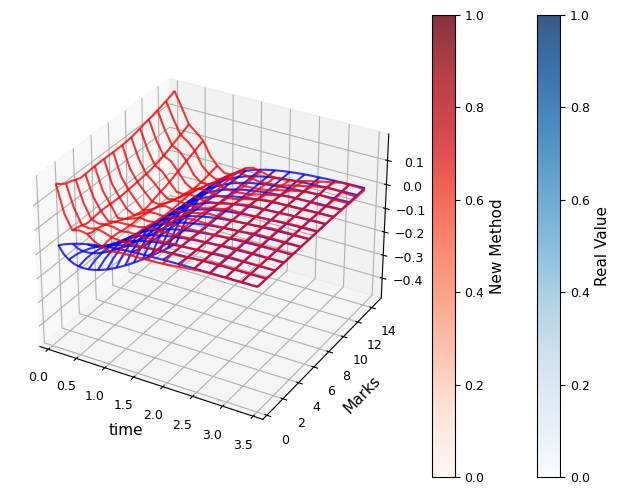

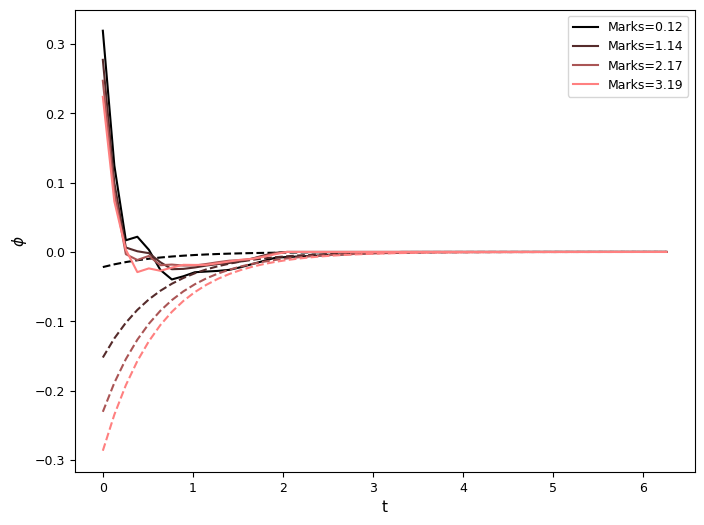

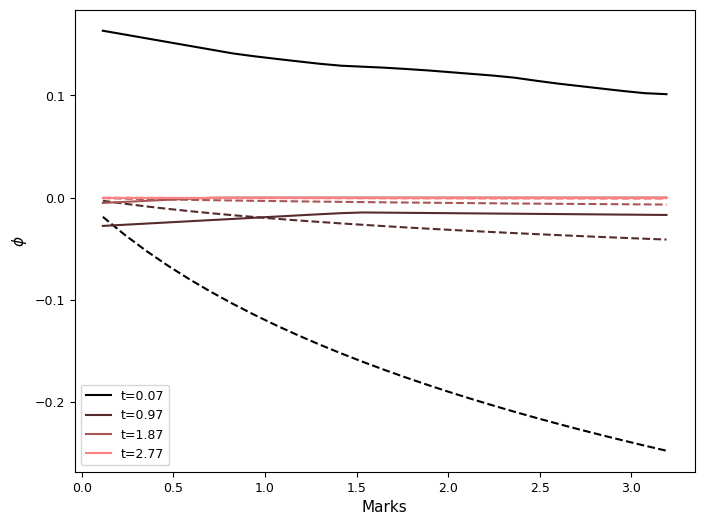

Integrated Part Mu and kernel  981.2618319193004
log Part 222.99608204151468
401 2 1204.2579139608151 1204.2579139608151 0.6684037960562722 7.82414692593856e-06
Integrated Part Mu and kernel  1017.183414073175
log Part 169.2806503268347
1401 2 1186.4640644000096 1186.4640644000096 0.6880086569858419 7.82414692593856e-06
Integrated Part Mu and kernel  1059.1155220038906
log Part 118.03428857494214
2401 2 1177.1498105788328 1177.1498105788328 0.7065801830828253 7.82414692593856e-06
Integrated Part Mu and kernel  1055.8135503183596
log Part 112.78976594736059
3401 2 1168.6033162657202 1168.6033162657202 0.720254317169393 7.82414692593856e-06
Integrated Part Mu and kernel  1072.0978284341738
log Part 93.3042727335087
4401 2 1165.4021011676825 1165.4021011676825 0.732253990150233 7.82414692593856e-06
Integrated Part Mu and kernel  1056.7853908440727
log Part 104.67683914973168
5401 2 1161.4622299938044 1161.4622299938044 0.7413685426407832 7.82414692593856e-06


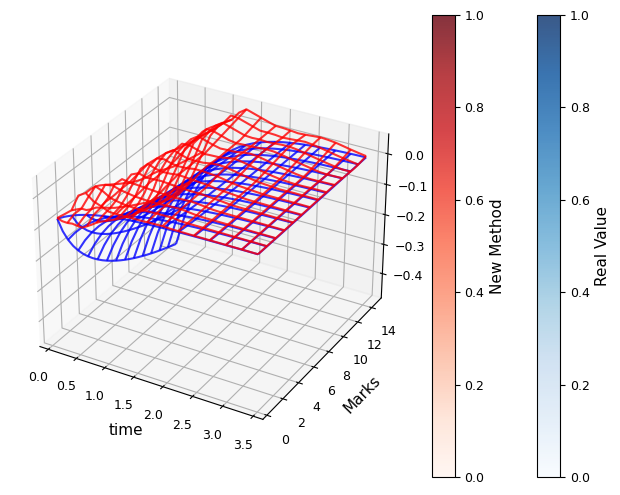

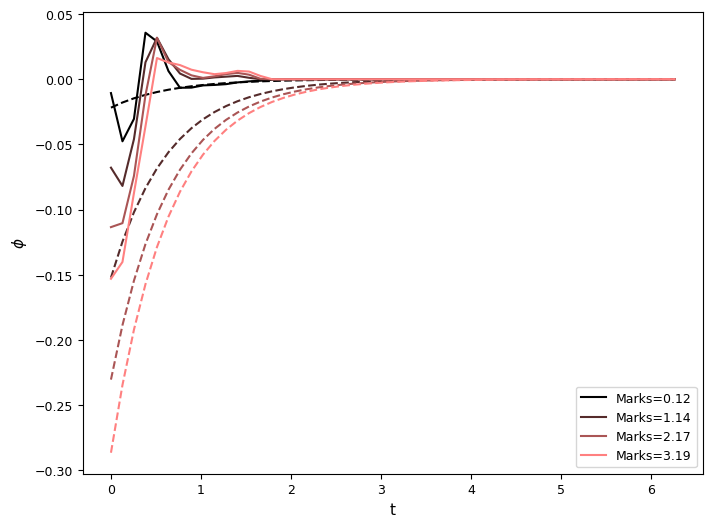

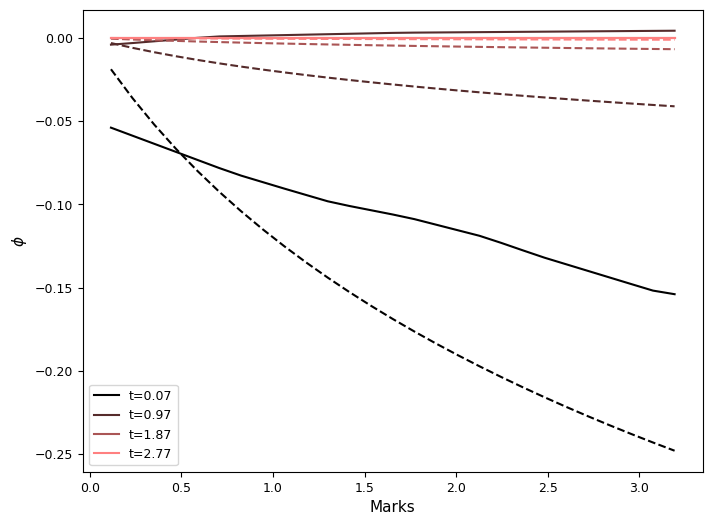

Integrated Part Mu and kernel  1109.2443893491043
log Part 54.72899688765142
901 3 1161.4622299938044 1163.9733862367557 0.7514428297465505 7.82414692593856e-06
Integrated Part Mu and kernel  1154.951144733977
log Part 16.02614895759484
1901 3 1161.4622299938044 1170.9772936915717 0.7589104014817553 7.82414692593856e-06
Integrated Part Mu and kernel  1134.930551540643
log Part 30.530337798058554
2901 3 1161.4622299938044 1165.4608893387015 0.7636938846697201 7.82414692593856e-06
Integrated Part Mu and kernel  1102.3985822437057
log Part 56.5971952690611
3901 3 1158.9957775127668 1158.9957775127668 0.7689714213222487 7.82414692593856e-06
Integrated Part Mu and kernel  1087.3763961938837
log Part 68.84058633083009
4901 3 1156.2169825247138 1156.2169825247138 0.7751852541063388 7.82414692593856e-06


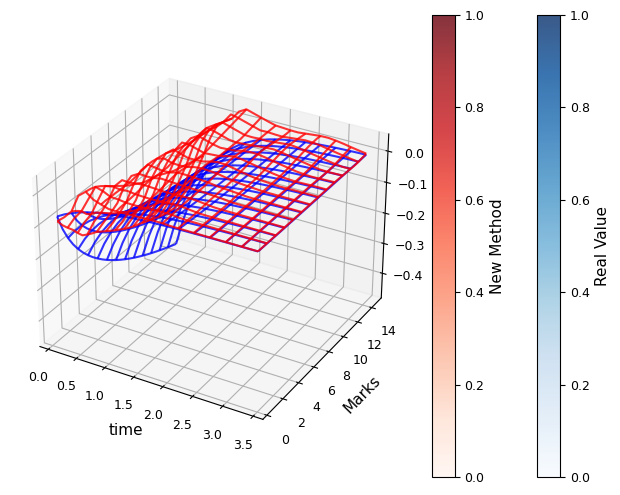

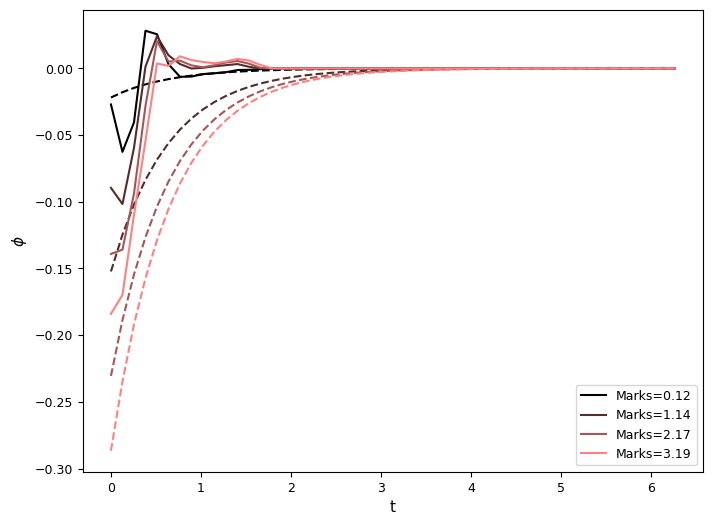

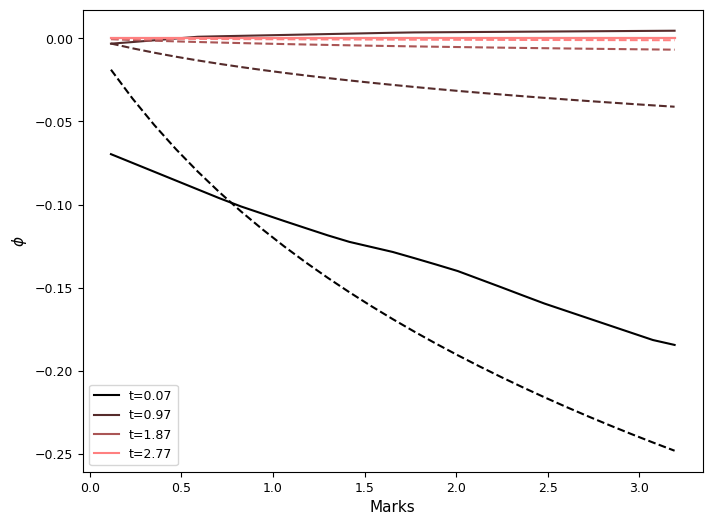

Integrated Part Mu and kernel  1093.8961160391175
log Part 61.492829633163865
401 4 1155.3889456722814 1155.3889456722814 0.7811978091537992 7.82414692593856e-06
Integrated Part Mu and kernel  1084.3726484177057
log Part 69.91471721455332
1401 4 1154.287365632259 1154.287365632259 0.7860655656104432 7.82414692593856e-06
Integrated Part Mu and kernel  1108.5401083661156
log Part 46.117741485621764
2401 4 1154.287365632259 1154.6578498517374 0.7924763607324034 7.82414692593856e-06
Integrated Part Mu and kernel  1132.3967761860577
log Part 23.205519242946366
3401 4 1154.287365632259 1155.602295429004 0.7988361439975605 7.82414692593856e-06
Integrated Part Mu and kernel  1142.0668158857152
log Part 13.211992644246493
4401 4 1154.287365632259 1155.2788085299617 0.804777536072035 7.82414692593856e-06
Integrated Part Mu and kernel  1139.6228594242007
log Part 14.35915827524218
5401 4 1153.9820176994428 1153.9820176994428 0.8086618477649024 7.82414692593856e-06


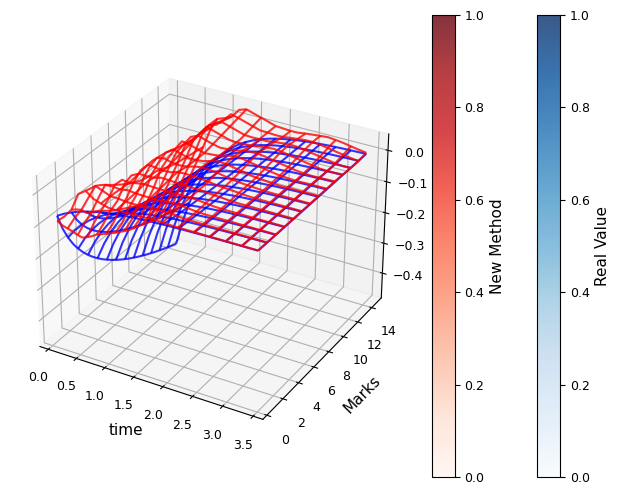

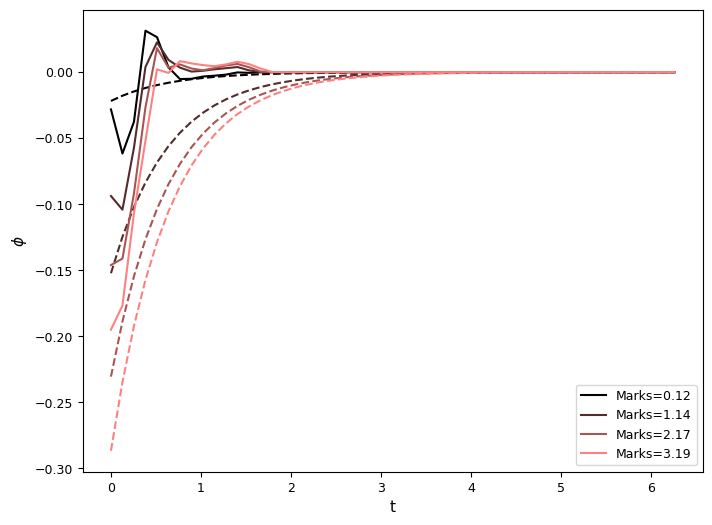

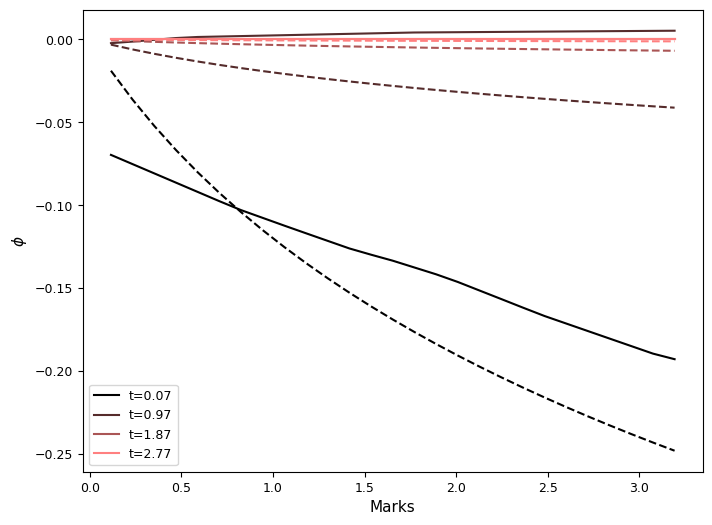

Integrated Part Mu and kernel  1135.0688623640433
log Part 17.894982607912198
901 5 1152.9638449719555 1152.9638449719555 0.8121016203616704 7.82414692593856e-06
Integrated Part Mu and kernel  1116.4829508018854
log Part 35.81135442485652
1901 5 1152.294305226742 1152.294305226742 0.8152679714616445 7.82414692593856e-06
Integrated Part Mu and kernel  1153.5596523310144
log Part 1.3073043612239417
2901 5 1152.294305226742 1154.8669566922383 0.8178909406965339 7.82414692593856e-06
Integrated Part Mu and kernel  1147.5001803913437
log Part 6.438651711271632
3901 5 1152.294305226742 1153.9388321026154 0.8199020739825532 7.82414692593856e-06
Integrated Part Mu and kernel  1135.6897268221408
log Part 16.32192136246863
4901 5 1152.0116481846094 1152.0116481846094 0.821924050249871 7.82414692593856e-06


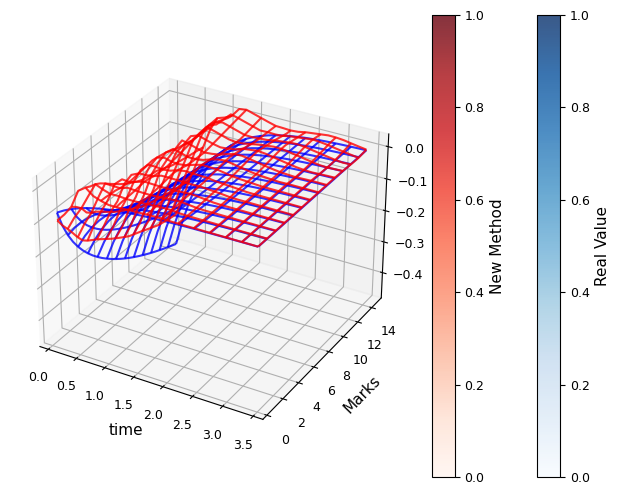

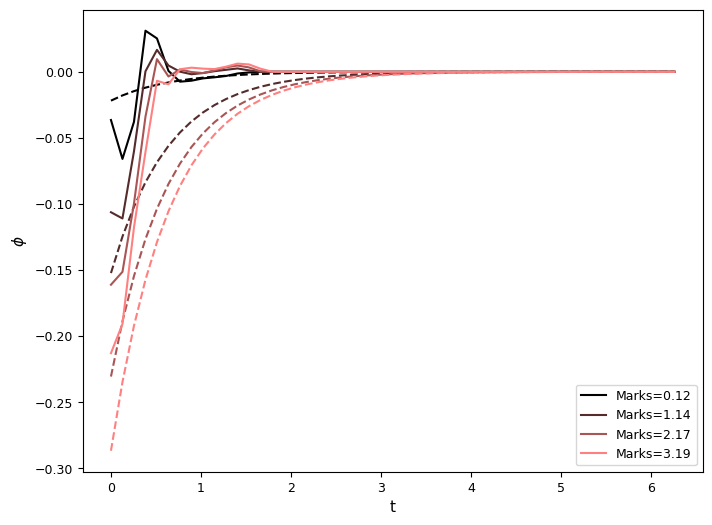

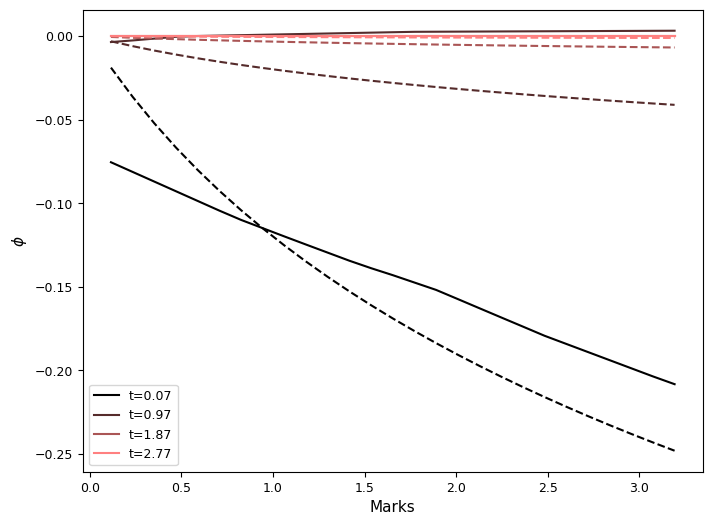

Integrated Part Mu and kernel  1159.269164218718
log Part -6.235522866385054
401 6 1152.0116481846094 1153.033641352333 0.827105133589741 7.82414692593856e-06
Integrated Part Mu and kernel  1148.4895060630602
log Part 3.6135402178581444
1401 6 1152.0116481846094 1152.1030462809183 0.8294762608359708 7.82414692593856e-06
Integrated Part Mu and kernel  1176.0080095708345
log Part -22.114349265530564
2401 6 1152.0116481846094 1153.893660305304 0.8331179153335067 7.82414692593856e-06
Integrated Part Mu and kernel  1177.4907503496422
log Part -23.458471224726736
3401 6 1152.0116481846094 1154.0322791249155 0.8348057761601927 7.82414692593856e-06
Integrated Part Mu and kernel  1163.114221001001
log Part -10.939018819500234
4401 6 1152.0116481846094 1152.1752021815007 0.8360943628224454 7.82414692593856e-06
Integrated Part Mu and kernel  1129.7637206694044
log Part 20.069145601411265
5401 6 1149.8328662708157 1149.8328662708157 0.8360439393183045 7.82414692593856e-06


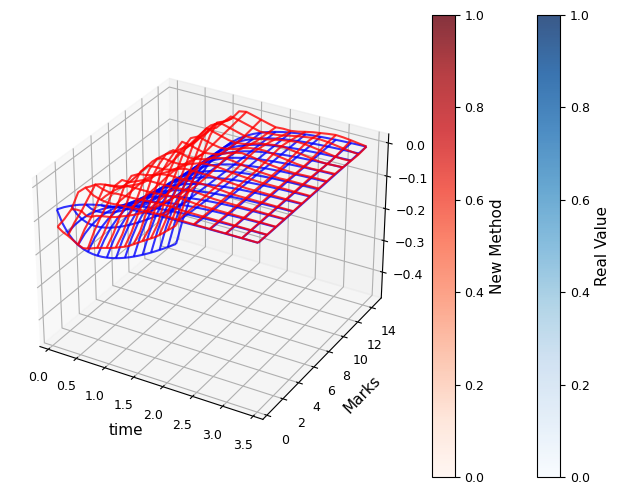

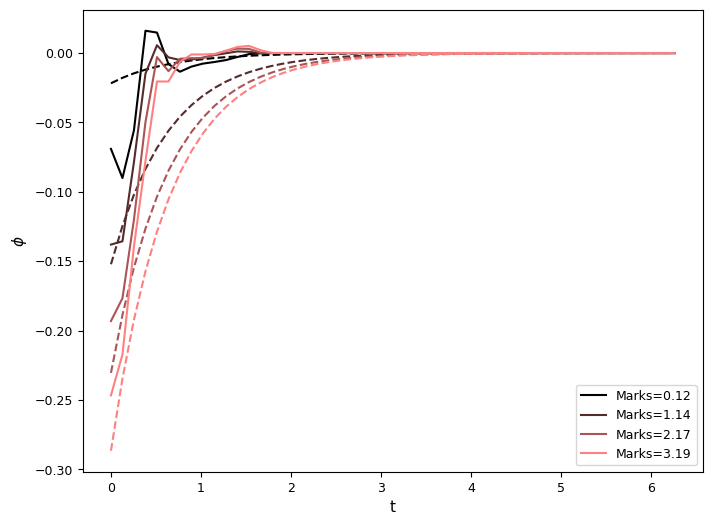

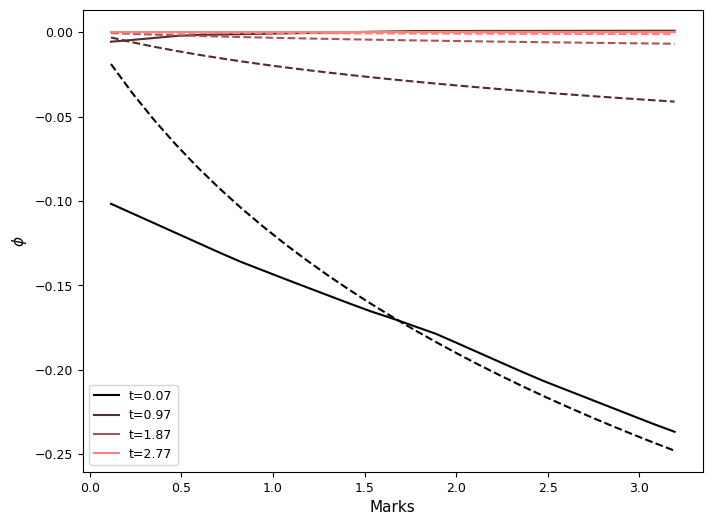

Integrated Part Mu and kernel  1134.7173965574493
log Part 15.264250768399506
901 7 1149.8328662708157 1149.9816473258488 0.838386465277039 7.82414692593856e-06
Integrated Part Mu and kernel  1146.2082901364133
log Part 4.3548981818416905
1901 7 1149.8328662708157 1150.563188318255 0.840754820305763 7.82414692593856e-06
Integrated Part Mu and kernel  1141.0855556718795
log Part 8.793116196972505
2901 7 1149.8328662708157 1149.878671868852 0.8438280674611455 7.82414692593856e-06
Integrated Part Mu and kernel  1126.340973901376
log Part 23.902926667672546
3901 7 1149.8328662708157 1150.2439005690485 0.8463060352702642 7.82414692593856e-06
Integrated Part Mu and kernel  1158.5185139350874
log Part -8.336764330322694
4901 7 1149.8328662708157 1150.1817496047647 0.8494176995248504 7.82414692593856e-06


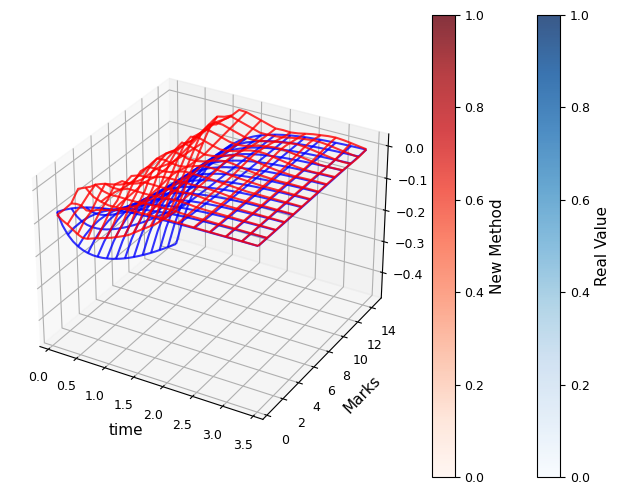

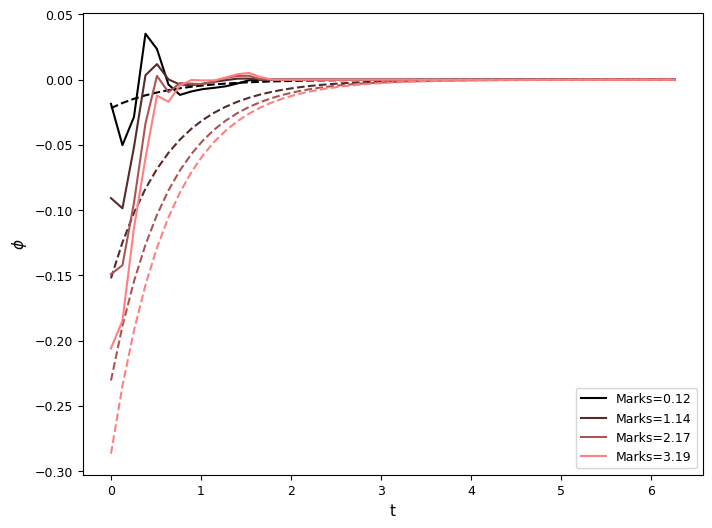

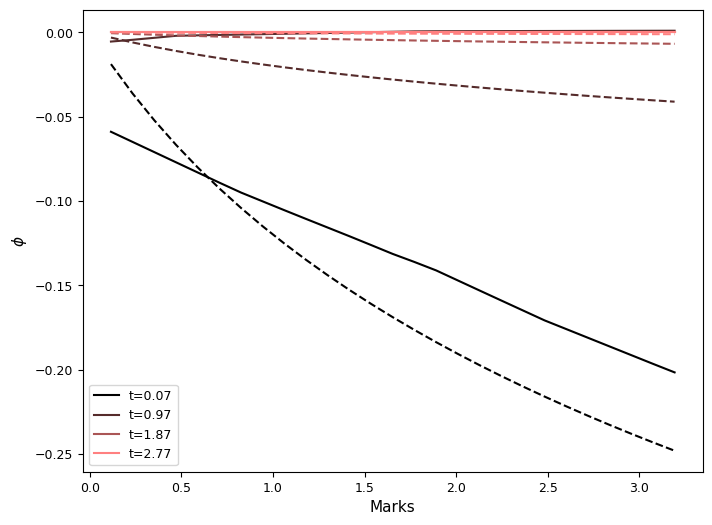

Integrated Part Mu and kernel  1196.4537302123103
log Part -42.402805909895505
401 8 1149.8328662708157 1154.0509243024148 0.8535049086062598 7.82414692593856e-06
Integrated Part Mu and kernel  1184.4345634747863
log Part -32.632056725050234
1401 8 1149.8328662708157 1151.802506749736 0.8556287883592095 7.82414692593856e-06
Integrated Part Mu and kernel  1141.5117001774236
log Part 8.826362082752212
2401 8 1149.8328662708157 1150.3380622601758 0.8558519175043204 7.82414692593856e-06
Integrated Part Mu and kernel  1201.4111578779527
log Part -46.57861930413628
3401 8 1149.8328662708157 1154.8325385738165 0.8573357342006643 7.82414692593856e-06
Integrated Part Mu and kernel  1175.034732652761
log Part -23.486115320260296
4401 8 1149.8328662708157 1151.5486173325007 0.8563170311754033 7.82414692593856e-06
Integrated Part Mu and kernel  1161.3257170033876
log Part -11.351548004147162
5401 8 1149.8328662708157 1149.9741689992404 0.8569282302437021 7.82414692593856e-06
1165.2175209522247


In [47]:

mus1grad=[]
musCgrad=[]
dictMus={}
dictIntegrate={}


dictgradient={}
epsilon = 1e-8

support=500
Dict={}
integratedDict={}
kerneltype=1


A=[]
B=[]
A_grad=[]
B_grad=[]
tseriesA = np.array([])

Dict_gradient={}


nNeurons=64
kernelType = 0
#mu_t,theta = 0.7,4
#betax=1.2
#t1,marksO=simu_univariateMarked1(mu_t,theta,betax,10000,mean,variance)


print("original Likelihood",loglikelihood([theta,betax,mu_t],t1,marksO))



fac=len(t1)/t1[-1]
facM=1/(np.mean(marksO))

tscale=t1.copy()*fac
marks1=marksO.copy()*facM
#tscale=np.append(0,tscale)
tmax=tscale[-1]

markFunctionLL= mark_distribution(marks1)
print("marksSum",markFunctionLL)
mu,c=initializeParams(nNeurons,fac,facM)

plotKernels()
inflectionPoints()

start=time.time()
print("len of datapoints",len(tscale))
def plotlambdas(mu_t):
    dx=0.01
    tseries= t1
    lambda_value=[]
    time_intervals=[]
    lambda_nn=[]
    lambdas_1=[]
    for i in range(1,len(tseries),1):
        lambdas=[]
        new_temp=np.linspace(tseries[i-1],tseries[i],1)
      
        temp=new_temp.reshape(-1,1)-tseries[0:i]
        markTemp=marksO[0:i]
        mu_t=mu_t    
        lambdas=mu_t+np.sum(markedFactorMultplied(markTemp,gamma)*(-0.5)*np.exp(-theta*temp),axis=1)

        time_intervals.append(new_temp)
        lambda_value.append(lambdas)
    time_intervals=(np.array(time_intervals)).reshape(-1)
    lambda_value=(np.array(lambda_value)).reshape(-1)
    plt.figure(figsize=(10,4))
    plt.plot(time_intervals,lambda_value,label='Real Intensity')

    plt.xlabel("t")
    plt.ylabel("$\lambda(t)$")
    plt.legend()
    plt.grid()
    plt.pause(0.001)
    
    
  
    return 0
plotlambdas(mu_t)
print("mean marks",np.mean(marksO))
markedNNNH=sgdNeuralHawkes(100,0.01,mu,c,tscale,marks1)
print(time.time()-start)
timestr = time.strftime("%Y%m%d-%H%M%S")
#np.save("results/"+timestr+"_NNNH.npy",{'Results':SGDNNNH,'Timestamps':tscale,'marks':marks1,'factor':fac,'mu':mu*fac})


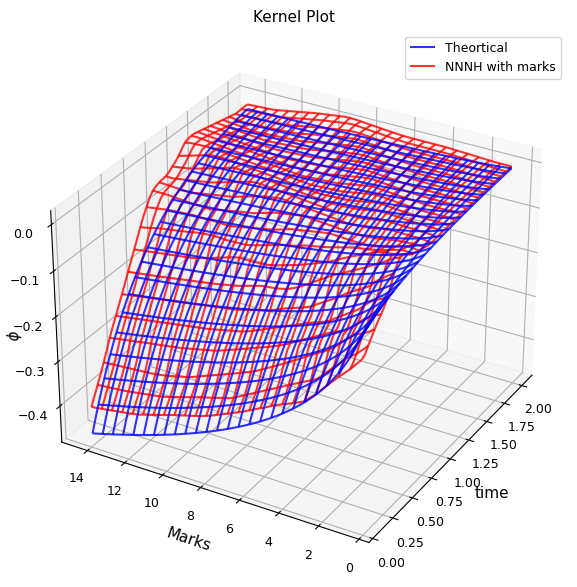

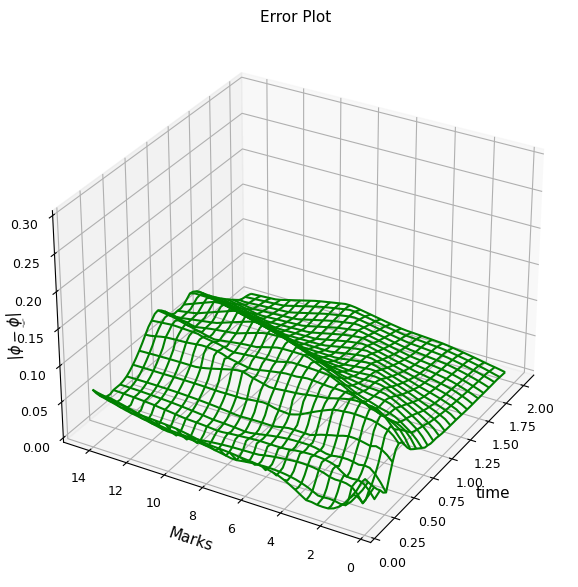

In [102]:
%matplotlib inline
def optimalValues():
    optimalAlphas=markedNNNH[0][0]
    optimalAlpha0=markedNNNH[0][1]
    optimalBetas1=markedNNNH[0][2]
    optimalBetas2=markedNNNH[0][3]
    optimalBeta0=markedNNNH[0][4]
    optimalMu=markedNNNH[0][5]/fac
    return optimalAlphas,optimalAlpha0,optimalBetas1,optimalBetas2,optimalBeta0,optimalMu

def nnKernelOptimal(x,mark):
    alphas,alpha0,betas1,betas2,beta0,mu=optimalValues()

    n1 = np.maximum(betas1*x.reshape(1,-1) + betas2*mark.reshape(1,-1)+beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    return y    

def nnKernelMatrixOptimal(x,y):
    z=np.zeros((len(x),len(y)))
    for i in range(len(x)):
        z[i,:]=nnKernelOptimal(x[i,:],y[i,:]).reshape(-1)
            
    return z

dx=0.03
    
marksplot=np.sort(marks1)
lengthMarks=len(marksplot)
marksMin=marksplot[int(0.05*lengthMarks)]
marksMax=marksplot[int(0.95*lengthMarks)]
diff_t=np.diff(tscale)
diff_tSort=np.sort(diff_t)
length_difftSort=len(diff_tSort)
diffMin= diff_tSort[int(0.05*length_difftSort)]
diffMax= diff_tSort[int(0.95*length_difftSort)]
tk =np.arange(diffMin,1.6,dx)
marksP=np.linspace(marksMin,marksMax,len(tk))
    
    
X, Y = np.meshgrid(tk, marksP)

if(kernelType == 0):
    #y = alpha*np.exp(-beta*tk)
    Z=markedFactorMultplied(Y/facM,gamma)*function_kernel1(theta,X)         
    
fig = plt.figure(figsize=(12,6))

plt.rc('axes', titlesize=11)    
plt.rc('axes', labelsize=11)   
plt.rc('xtick', labelsize=9)    
plt.rc('ytick', labelsize=9)    
plt.rc('legend', fontsize=9 )   
plt.rc('font', size=11)  
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_wireframe(X/fac, Y/facM, Z, cmap="Blues",
                       rstride=2, cstride=2, alpha=0.8,color="blue",label="Theortical")

Z2=nnKernelMatrixOptimal(X,Y)*fac  

surf1 = ax.plot_wireframe(X/fac, Y/facM, Z2, cmap="Reds",
                       rstride=2, cstride=2,alpha=0.8,color="red" ,label="NNNH with marks")


ax.set_xlabel('time')
ax.set_ylabel('Marks')
ax.set_zlabel('$\phi$')
ax.zaxis.labelpad=-3     
ax.set_title('Kernel Plot')
plt.grid()
fig.tight_layout()
plt.legend()
ax.view_init(30, -150) 
plt.savefig("results/1dNNNH_neg.jpg",dpi=100,bbox_inches='tight')
plt.pause(0.0005)
X, Y = np.meshgrid(tk, marksP)
fig = plt.figure(figsize=(12,6))
plt.rc('axes', titlesize=11)    
plt.rc('axes', labelsize=11)   
plt.rc('xtick', labelsize=9)    
plt.rc('ytick', labelsize=9)    
plt.rc('legend', fontsize=9 )   
plt.rc('font', size=11)  

ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_wireframe(X/fac, Y/facM, np.abs(Z2-Z), cmap="Greens",
                       rstride=2, cstride=2, color="green",label="error")


ax.set_xlabel('time')
ax.set_ylabel('Marks')
ax.set_zlabel('$|\widehat{\phi}-\phi|$')
ax.zaxis.labelpad=-3
ax.set_zlim(0, 0.3)
ax.set_title('Error Plot')
plt.grid()
fig.tight_layout()
ax.view_init(30, -150) 
plt.savefig("results/1dNNNH_error.jpg",dpi=200,bbox_inches='tight')
plt.pause(0.0005)

    

Integrated Part Mu and kernel  1059.6566909551939
log Part 113.66405978792613
901 1 1173.32075074312 1173.32075074312 0.7306704993652309 7.82414692593856e-11
Integrated Part Mu and kernel  1075.8739865587438
log Part 88.24456652605954
1901 1 1164.1185530848034 1164.1185530848034 0.7609596747462118 7.82414692593856e-11
Integrated Part Mu and kernel  1157.9750778563869
log Part 4.480438705261122
2901 1 1162.455516561648 1162.455516561648 0.8066447356146237 7.82414692593856e-11
Integrated Part Mu and kernel  1151.3659919489398
log Part 5.7915761264007415
3901 1 1157.1575680753406 1157.1575680753406 0.8260019966933992 7.82414692593856e-11
Integrated Part Mu and kernel  1146.1203952037856
log Part 7.439856684656206
4901 1 1153.5602518884418 1153.5602518884418 0.8487287934055182 7.82414692593856e-11


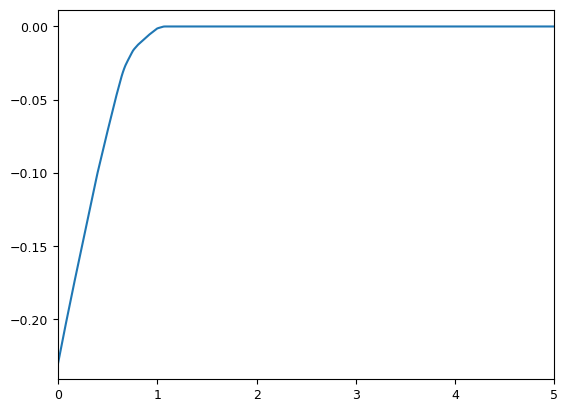

Integrated Part Mu and kernel  1218.572037227161
log Part -61.57371298934686
401 2 1153.5602518884418 1156.9983242378141 0.8802822623838511 7.82414692593856e-11
Integrated Part Mu and kernel  1147.270811849255
log Part 29.129505204556835
1401 2 1153.5602518884418 1176.400317053812 0.8942932207065054 7.82414692593856e-11
Integrated Part Mu and kernel  1207.4182970409806
log Part -53.53769746774424
2401 2 1153.5602518884418 1153.8805995732364 0.8993972517431477 7.82414692593856e-11
Integrated Part Mu and kernel  1236.7422534812124
log Part -79.74419107268841
3401 2 1153.5602518884418 1156.998062408524 0.9012025940212779 7.82414692593856e-11
Integrated Part Mu and kernel  1206.857691912558
log Part -52.669677662850745
4401 2 1153.5602518884418 1154.1880142497073 0.9015231784253561 7.82414692593856e-11
Integrated Part Mu and kernel  1197.3424611966723
log Part -43.18789109211593
5401 2 1153.5602518884418 1154.1545701045563 0.9015149680464846 7.82414692593856e-11


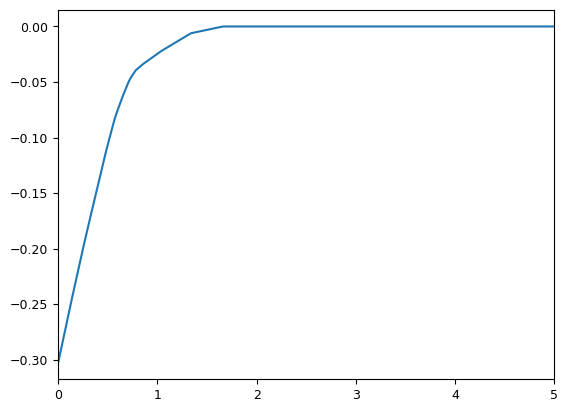

Integrated Part Mu and kernel  1205.6609694769431
log Part -50.72474596517395
901 3 1153.5602518884418 1154.9362235117692 0.9109694581599715 7.82414692593856e-11
Integrated Part Mu and kernel  1175.018503395934
log Part 3.0035102794997783
1901 3 1153.5602518884418 1178.0220136754338 0.9261943693522169 7.82414692593856e-11
Integrated Part Mu and kernel  1352.452179503849
log Part -179.17055378981172
2901 3 1153.5602518884418 1173.2816257140373 0.9589588635194282 7.82414692593856e-11
Integrated Part Mu and kernel  1394.475671905302
log Part -211.98816601958288
3901 3 1153.5602518884418 1182.4875058857192 0.9704404371096989 7.82414692593856e-11
Integrated Part Mu and kernel  1407.5505434076222
log Part -221.93535193172283
4901 3 1153.5602518884418 1185.6151914758993 0.9744639098015146 7.82414692593856e-11


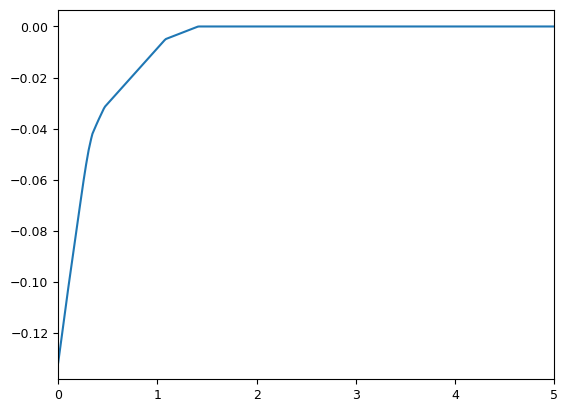

Integrated Part Mu and kernel  1411.95644977349
log Part -225.2689916041711
401 4 1153.5602518884418 1186.687458169319 0.9758738524399737 7.82414692593856e-11
Integrated Part Mu and kernel  1413.4798487262015
log Part -226.41855023789435
1401 4 1153.5602518884418 1187.061298488307 0.976367937571167 7.82414692593856e-11
Integrated Part Mu and kernel  1414.0112075945738
log Part -226.81912722864604
2401 4 1153.5602518884418 1187.1920803659277 0.9765410779101013 7.82414692593856e-11
Integrated Part Mu and kernel  1414.197106673235
log Part -226.95924106753023
3401 4 1153.5602518884418 1187.2378656057049 0.9766017505690994 7.82414692593856e-11
Integrated Part Mu and kernel  1414.2622128093428
log Part -227.00830867174022
4401 4 1153.5602518884418 1187.2539041376026 0.9766230114254012 7.82414692593856e-11
Integrated Part Mu and kernel  1414.285022475131
log Part -227.02549845120188
5401 4 1153.5602518884418 1187.259524023929 0.9766304613937745 7.82414692593856e-11


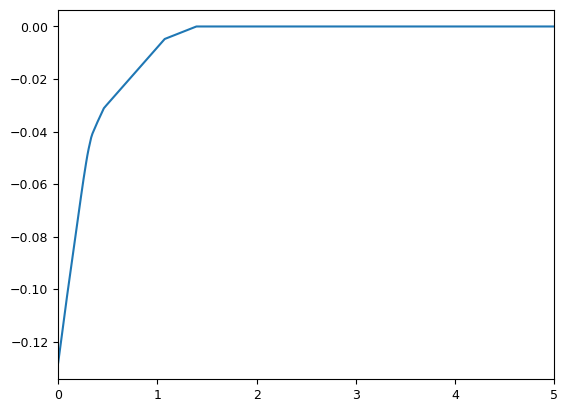

Integrated Part Mu and kernel  1414.2930141307288
log Part -227.031520809928
901 5 1153.5602518884418 1187.2614933208008 0.9766330715437272 7.82414692593856e-11
Integrated Part Mu and kernel  1414.2958138062652
log Part -227.03363056263902
1901 5 1153.5602518884418 1187.2621832436262 0.9766339857790467 7.82414692593856e-11
Integrated Part Mu and kernel  1414.2968068325717
log Part -227.0343797242649
2901 5 1153.5602518884418 1187.2624271083068 0.9766343141923843 7.82414692593856e-11
Integrated Part Mu and kernel  1414.297161486122
log Part -227.03464775449038
3901 5 1153.5602518884418 1187.2625137316315 0.976634433789489 7.82414692593856e-11
Integrated Part Mu and kernel  1414.2972849788166
log Part -227.0347410434897
4901 5 1153.5602518884418 1187.262543935327 0.9766344752470344 7.82414692593856e-11


In [90]:
%matplotlib inline
import NNNHUnivariate as NNNH
NonMarkedNNNH=NNNH.sgdNeuralHawkes(tscale,fac)
def nnMarkedNonoptimalKernel(x):
    alphas=NonMarkedNNNH[0][0]
    alpha0=NonMarkedNNNH[0][1]
    betas=NonMarkedNNNH[0][2]
    beta0=NonMarkedNNNH[0][3]
    n1 = np.maximum(betas*x.reshape(1,-1) + beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0

    return y

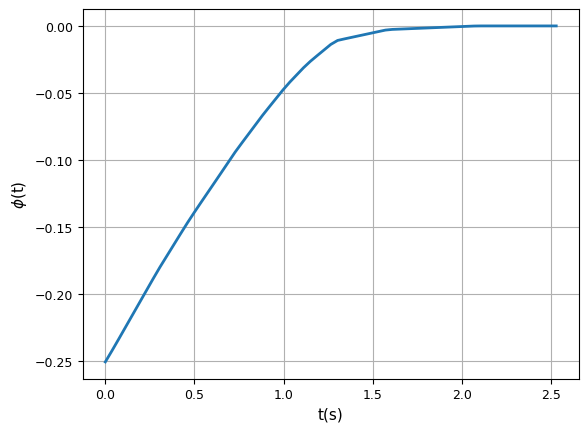

In [64]:
tk =np.arange(0,2,dx)
kernelNonMarked= nnMarkedNonoptimalKernel(tk.reshape(1,-1))*fac
plt.plot(tk/fac,kernelNonMarked.reshape(-1),linewidth=2)
plt.ylabel("$\phi$(t)")
plt.xlabel("t(s)")



plt.grid()

plt.savefig('results/NNNHNonMarked.png', dpi=300, transparent=False, bbox_inches='tight')

0.39718799581992636 0.4345196349107861
0.04086715177330107 0.04620549777679574
0.47885448704186 0.4836910922007466
0.33483783811647355 0.3431029036727899
0.7161379727206899 0.7328227034498102
0.07911153096478653 0.08048994071749843
1.34861765213873 1.4516648987055738
2.379460708108173 2.4920113060729294
2.0883517525643187 2.101463121313094
1.4294716669050442 1.4471999367734778
0.6505747412106496 0.6848327755555832
2.738930790520019 2.7919278039019404
2.2983776445163953 2.2778156271340118
0.07925056933611213 0.0737683919651121
1.1246007340219006 1.1496394467724684
0.07833498886748216 0.06666117273482573
0.16551301382881212 0.1426021423104695
1.537927661079356 1.53317894391795
0.6959140273136692 0.8233062990396082
0.2024631003738068 0.20844691011600483
0.6210274833065966 0.6336695459996855
0.1195657639825106 0.11309212387706263
0.5617450179404359 0.5660478614881767
2.618992609492499 2.612247504419465
2.160663879207692 2.264055565746668
1.0110082618692502 0.9652012641829453
0.990809761546

1.8154593709839575 1.7901771986646375
0.5241403947055043 0.537145392303391
3.208418055638785 3.2874338098382796
1.225380706478651 1.3544601454950898
0.2698927125329131 0.29268319744779814
0.15915337861053672 0.1859122234435261
0.7110386545414947 0.6652600639918734
2.1357301963741935 2.1854409090101132
0.8929473694485843 0.9079216856065476
0.6560384726057044 0.714298431493428
2.0057313912746526 2.0233974931049308
2.0104263440896895 2.1214502154651624
0.23251167051796712 0.2945820290663678
1.1420031489072826 1.1371009663623635
0.07536874969273841 0.06649480136489072
1.1740217006472875 1.0845078165114261
0.9490206172166166 0.8927538976469127
0.16563074726565963 0.2299775913056429
0.459575031335433 0.5847331093950131
1.041293162850487 1.006120406060804
0.3518268844976601 0.33656473961531136
0.9110607610016385 0.9705154397060797
0.14085014780978838 0.13426611213991163
0.3902901174756488 0.3431258128739518
0.8176193015647691 0.793145522229947
0.21072611447479236 0.25806303803566993
2.1098467

0.37692001098944516 0.34318488947775955
3.0084208474323018 2.9618100428201766
0.08963542052462507 0.11691328923871537
0.23727744509771473 0.2603439415076089
0.2049408121336265 0.2083137042133599
0.20349203797218235 0.21483563553327725
2.475372162943352 2.4272462621505047
1.0819409392638097 1.036777104407506
1.7789415316921295 1.7885908380523245
3.532918454986799 3.527856305760625
1.4735398675072788 1.4411330600753722
2.1946460555287697 2.161627131748932
0.7163811973252713 0.7130694731037506
0.22966747074844313 0.21081998122600348
7.070165221352533 7.090881987499662
0.5644961964852621 0.6925623986141795
0.20047975357190154 0.2402427364716227
1.629276882588706 1.6191901808235265
0.5570189940470435 0.5977219807978813
0.9346664707734998 0.9941758689291638
0.04689436410219576 0.05191636328714244
1.7092254507186273 1.686787913354326
0.35833771328621145 0.33013015034401927
0.5327644562130187 0.6555629905103993
0.21860635747515084 0.22624808072059718
0.7217430261732234 0.8645036102571126
1.076

0.3878270536074259 0.33370766117497463
1.1209759856589376 1.0795433078789574
0.8272459590020648 0.9800281674178395
5.376979944531122 5.428064598228529
0.8089555789216941 0.7564460220952018
0.663784529763683 0.6204338338232328
0.2278898922532188 0.21107675903724893
1.23453471241685 1.218777139472831
2.378044063241191 2.4107852342546217
2.788327775685971 2.8339664899283803
0.19640343641155558 0.18175892009217376
0.6120460063494613 0.5896650547057586
1.5931493990761163 1.6304409353487495
0.713368310013556 0.6573812943702737
0.4873524805284251 0.491525570397119
0.2429936700866104 0.21056068928708546
0.12020217725549164 0.08741499581011565
1.3989045316002184 1.4533924379329488
1.6340498036794286 1.7482422854760755
0.5280881370782208 0.4828682009436866
0.23794996946902008 0.2732675976114302
3.7512272816435663 4.120049862916347
0.049526279657147995 0.058212686715197526
0.010808020651080412 0.010156595392807246
0.6563789048507571 0.6982415586934251
0.7412226916431621 0.7177673700825435
0.61634

0.35476404341755896 0.3791031519266016
0.9454073274196679 0.9611106447191744
0.056034997774946735 0.05827161750140781
1.1426000452664593 1.1070805235676862
2.8546971275330484 2.9036019093661753
0.6724409584667799 0.6220509612967622
1.152862222871362 1.1719907647783931
0.7863353534264914 0.8273189632253
2.561974484833666 2.5753735140636116
0.23986374522928308 0.21405240948010665
3.4716619280264513 3.4441300889949478
0.05801979159089885 0.06826135119633879
1.5762028022627648 1.574229473018648
0.6951152786899004 0.6787414715963043
0.2297719894982839 0.23461125277086817
1.4104763205080952 1.3534489817447137
1.3658063772787004 1.3203537628029989
2.044296118626213 2.2017503057084
0.8475835310201959 0.9767267500596742
0.09179455494788945 0.10640904935665738
4.467228283004307 4.506590714711749
0.17566068248421882 0.18099123521379867
0.21719582028527656 0.20213694311525238
1.3359599542531586 1.2807434562590827
1.359645801810137 1.5103650676664664
0.02411896720559349 0.025996318325751996
0.99792

0.2246850194890634 0.20089310006597744
0.5578964609782775 0.5412182470249199
0.9038729004742087 0.9114707961387455
2.9589484413372213 2.9277664264072025
2.209451345288218 2.2084732153290565
0.3126621788951071 0.2859722305343764
0.048027239038617206 0.03518596648684205
0.03008247651091745 0.016102058429254308
0.9246579268770888 0.7723360072166515
0.26113412945694037 0.2776938815829628
0.7165467257909082 0.6878402479472099
1.1834773196108221 1.1750490003962524
2.2775021797688364 2.3111537763989602
0.30820281160551605 0.2753084168497213
0.987289329134426 0.9734815801725453
1.5419268288695012 1.504324586176301
0.692136131641735 0.79334613408583
3.9681076046053194 4.3258960664736295
0.018076739532648555 0.016981676813481998
0.7419396492878692 0.8007859213460647
2.941055106887348 2.956596055313977
1.344288632311554 1.311809862625365
0.9820717418802569 0.9431170783853023
0.4602006051572991 0.4341694399487335
2.537839095354497 2.5041760932587724
1.6985590808871993 1.7366130389221641
1.67945047

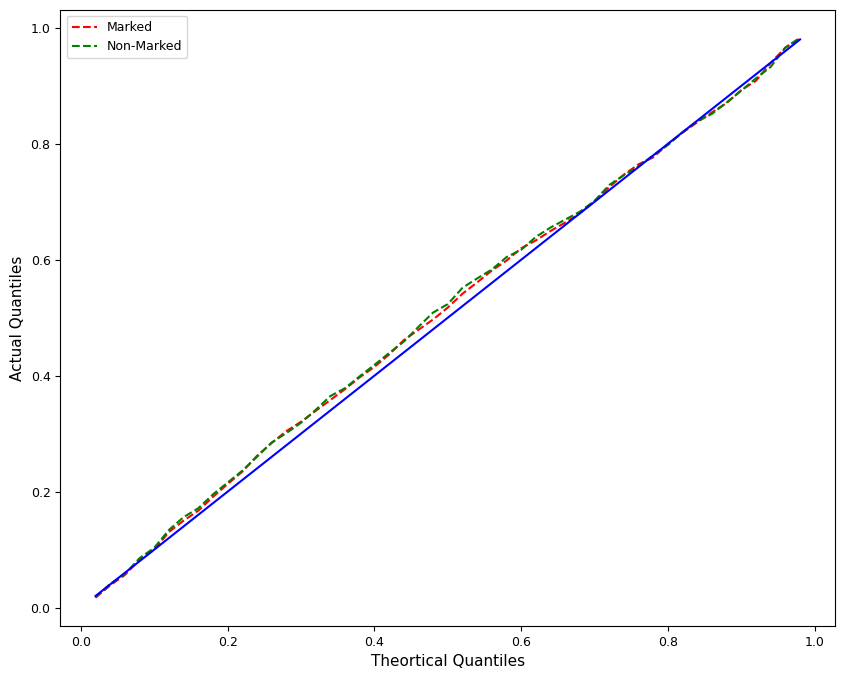

In [103]:
def qqplot(t_test,marks_test):
    optimalMu=markedNNNH[0][5]
    optimalMuNonMarked=NonMarkedNNNH[0][4]
    interArrP=[]
    interArrPNonMarked=[]
    for i in range(1,len(t_test),1):
        li = max(i-support,0)
        temp=t_test[li:i]
        markTemp=marks_test[li:i]
        uppLim=t_test[i]
        lowLim=t_test[i-1]
        intLambda_NNNH=0
        intLambda_NNNHNonMarked=0
        rangeInt=np.linspace(lowLim,uppLim,50)
        diff=rangeInt[1]-rangeInt[0]
        for j in range(len(rangeInt)):
            intLambda_NNNH+=diff*(optimalMu+(nnKernelOptimal(rangeInt[j]-temp,markTemp)).sum())
            intLambda_NNNHNonMarked+=diff*(optimalMuNonMarked+(nnMarkedNonoptimalKernel(rangeInt[j]-temp[-100:])).sum())
        interArrP.append(np.exp(-intLambda_NNNH))
        interArrPNonMarked.append(np.exp(-intLambda_NNNHNonMarked))
    interArrP=np.array(interArrP)
    interArrPNonMarked=np.array(interArrPNonMarked)
    
    probs=np.arange(0.02,1,0.02)
    qq=[]
    qqNonMarked=[]
    for k in (probs):
        qq.append(len(interArrP[interArrP<=k])/len(interArrP))
        qqNonMarked.append(len(interArrPNonMarked[interArrPNonMarked<=k])/len(interArrPNonMarked))
    plt.figure(figsize=(10,8))
    plt.rc('axes', titlesize=11)    
    plt.rc('axes', labelsize=11)   
    plt.rc('xtick', labelsize=9)    
    plt.rc('ytick', labelsize=9)    
    plt.rc('legend', fontsize=9 )   
    plt.rc('font', size=11)      
    plt.plot(probs,qq,'r--',label="Marked")
    plt.plot(probs,qqNonMarked,'g--',label="Non-Marked")
    plt.plot(probs,probs,'b-')
    plt.xlabel('Theortical Quantiles')
    plt.ylabel('Actual Quantiles')
    plt.legend()
    plt.savefig('results/NNNHQQPlot.jpg',dpi=100, bbox_inches='tight')
    plt.pause(0.005)
    return
testLen=int(len(tscale)*0.85)   
qqplot(tscale[testLen:],marks1[testLen:])
    

[-1.01001718]
[-4.31507369]
[-3.89646697]
[-1.95620337]
[-1.35552686]
[-1.93202152]
[-0.80549978]
[-0.18843227]
[-0.76311348]
[-0.67143813]
[-1.42861841]
[-0.1831699]
[-0.4173034]
[-3.06756099]
[-1.15907584]
[-1.8129996]
[-3.01067015]
[-1.5585897]
[-0.9909938]
[0.         0.         0.         0.         0.         0.
 0.03054416 0.64761166 0.07293046 0.16460581 0.         0.65287404
 0.41874054 0.         0.         0.         0.         0.
 0.        ] [6606.56152977 6606.61516291 6606.66879605 6606.72242919 6606.77606233
 6606.82969547 6606.88332861 6606.93696175 6606.99059489 6607.04422802
 6607.04422802 6607.05139213 6607.05855624 6607.06572036 6607.07288447
 6607.08004858 6607.08721269 6607.0943768  6607.10154091 6607.10870502
 6607.10870502 6607.17776134 6607.24681767 6607.315874   6607.38493033
 6607.45398666 6607.52304298 6607.59209931 6607.66115564 6607.73021197
 6607.73021197 6607.77422411 6607.81823626 6607.86224841 6607.90626056
 6607.9502727  6607.99428485 6608.038297   6

ValueError: x and y must have same first dimension, but have shapes (190,) and (19,)

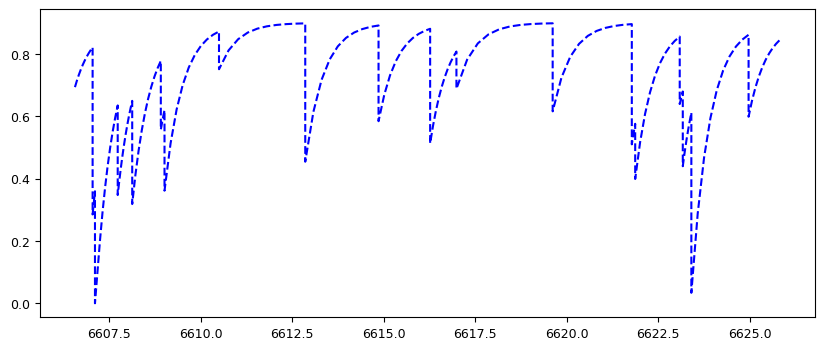

In [122]:

def plotlambdas(mu_t,req):
    dx=0.01
    optimalMu=markedNNNH[0][5]*fac
    optimalMuNonMark=NonMarkedNNNH[0][4]*fac
    tseries= tscale[testLen:testLen+req]
    lambda_value=[]
    time_intervals=[]
    lambda_nn=[]
    lambdas_nn_non=[]
    lambdas_1=[]
    
    for i in range(1,len(tseries),1):
        new_temp=np.linspace(tseries[i-1],tseries[i],10)
        temp=new_temp.reshape(-1,1)-tseries[0:i]
        markTemp=marks1[0:i]*np.ones(temp.shape)
        mu_t=mu_t
        print(np.sum(nnKernelOptimal(temp,markTemp)*fac ,axis=1))
        lambdas=np.maximum(0,mu_t+np.sum(markedFactorMultplied(markTemp/facM,gamma)*function_kernel1(theta,temp),axis=1))
        lambdas_NNNH=np.maximum(0,optimalMu+np.sum(nnKernelOptimal(temp,markTemp)*fac ,axis=1))
        lambdas_NNNHNonMarked=np.maximum(0,optimalMuNonMark+np.sum(nnMarkedNonoptimalKernel(temp)*fac ,axis=1))
        time_intervals.append(new_temp.reshape(-1))
        lambda_value.append(lambdas.reshape(-1))
        lambda_nn.append(lambdas_NNNH.reshape(-1))
        lambdas_nn_non.append(lambdas_NNNHNonMarked.reshape(-1))
    time_intervals=(np.array(time_intervals)).reshape(-1)
    lambda_value=(np.array(lambda_value)).reshape(-1)
    lambda_nn=np.array(lambda_nn).reshape(-1)
    lambdas_nn_non=np.array(lambdas_nn_non).reshape(-1)
    print(lambda_nn,time_intervals)
    plt.figure(figsize=(10,4))
    plt.plot(time_intervals,lambda_value,'b--',label='Real Intensity')
    plt.plot(time_intervals,lambda_nn,'r-',label='Intensity of NNNH with marks')
    plt.plot(time_intervals,lambdas_nn_non,'g-',label='Intensity of NNNH ')
    
    plt.rc('axes', titlesize=11)    
    plt.rc('axes', labelsize=11)   
    plt.rc('xtick', labelsize=9)    
    plt.rc('ytick', labelsize=9)    
    plt.rc('legend', fontsize=9 )   
    plt.rc('font', size=11) 
    plt.xlabel("t")
    plt.ylabel("$\lambda(t)$")
    plt.legend()
    plt.grid()
    plt.pause(0.0005)
 
    # Create linear regression object
   

    #plt.plot(np.arange(0,12,0.1),np.arange(0,12,0.1))
    plt.pause(0.005)
plotlambdas(mu_t,20)